# Custom Evaluation with LlamaIndex

Reference: [Fine-Tuning Embeddings for RAG with Synthetic Data](https://medium.com/llamaindex-blog/fine-tuning-embeddings-for-rag-with-synthetic-data-e534409a3971)


In this notebook, we evaluate 3 different embedding models: 
1. proprietary OpenAI embedding,
2. open source `BAAI/bge-small-en`, and
3. our finetuned embedding model.

We consider 2 evaluation approaches:
1. a simple custom **hit rate** metric
2. using `InformationRetrievalEvaluator` from sentence_transformers

Finetuning on a synthetic (LLM-generated) dataset should improve performance compared to opensource embedding models.

In [12]:
import json
# from tqdm.notebook import tqdm
from tqdm import tqdm
import pandas as pd

from sentence_transformers.evaluation import InformationRetrievalEvaluator
from sentence_transformers import SentenceTransformer

from llama_index import ServiceContext, VectorStoreIndex
from llama_index.schema import TextNode
from llama_index.embeddings import OpenAIEmbedding

## Load data

In [2]:
TRAIN_DATASET_FPATH = 'afa_docs/train_val_data/train_dataset.json'
VAL_DATASET_FPATH = 'afa_docs/train_val_data/val_dataset.json'

In [4]:
with open(TRAIN_DATASET_FPATH, 'r+') as f:
    train_dataset = json.load(f)

with open(VAL_DATASET_FPATH, 'r+') as f:
    val_dataset = json.load(f)

## Eval function

**Option 1**: simple `hit rate` metric for evaluation.

For each `(query, relevant_doc)` pair,:
1. Retrieve top-k documents based on the query
2. Evaluate as `hit` if the retrievedf results contain the relevant_doc

In [6]:
def evaluate(
    dataset,
    embed_model,
    top_k=5,
    verbose=False,
):
    corpus = dataset['corpus']
    queries = dataset['queries']
    relevant_docs = dataset['relevant_docs']

    service_context = ServiceContext.from_defaults(embed_model=embed_model)
    nodes = [TextNode(id_=id_, text=text) for id_, text in corpus.items()] 
    index = VectorStoreIndex(
        nodes, 
        service_context=service_context, 
        show_progress=True
    )
    retriever = index.as_retriever(similarity_top_k=top_k)

    eval_results = []
    for query_id, query in tqdm(queries.items()):
        retrieved_nodes = retriever.retrieve(query)
        retrieved_ids = [node.node.node_id for node in retrieved_nodes]
        expected_id = relevant_docs[query_id][0]
        is_hit = expected_id in retrieved_ids  # assume 1 relevant doc
        
        eval_result = {
            'is_hit': is_hit,
            'retrieved': retrieved_ids,
            'expected': expected_id,
            'query': query_id,
        }
        eval_results.append(eval_result)
    return eval_results

**Option 2**: `InformationRetrievalEvaluator` from `sentence_transformers`.

**InformationRetrievalEvaluator** provides a more comprehensive suite of metrics, but it can be used **ONLY** wiht the models compatible wiht `sentencetransformers` library. That is, we can run it on an open source model and our finetuned model, but **NOT** wiht the OpenAI embedding model.

In [9]:
def evaluate_st(dataset, model_id, name):
    corpus = dataset['corpus']
    queries = dataset['queries']
    relevant_docs = dataset['relevant_docs']

    evaluator = InformationRetrievalEvaluator(queries, corpus, relevant_docs, name=name)
    model = SentenceTransformer(model_id)
    return evaluator(model, output_path='results/')

## Evaluate

### OpenAI

Note: this might take a few minutes to run since we have to embed the corpus and queries

In [11]:
ada = OpenAIEmbedding()
ada_val_results = evaluate(val_dataset, ada)

100%|██████████| 22/22 [00:15<00:00,  1.46it/s]


In [17]:
df_ada = pd.DataFrame(ada_val_results)
hit_rate_ada = df_ada['is_hit'].mean()
hit_rate_ada

0.7272727272727273

### BAAI/bge-small-en

In [15]:
bge = "local:BAAI/bge-small-en"
bge_val_results = evaluate(val_dataset, bge)

100%|██████████| 22/22 [00:00<00:00, 57.76it/s]


In [16]:
df_bge = pd.DataFrame(bge_val_results)
hit_rate_bge = df_bge['is_hit'].mean()
hit_rate_bge

0.6818181818181818

In [19]:
evaluate_st(val_dataset, "BAAI/bge-small-en", name='bge')

0.555633463387474

### Finetuned model

In [20]:
finetuned = "local:exp_finetune"
val_results_finetuned = evaluate(val_dataset, finetuned)

100%|██████████| 22/22 [00:00<00:00, 68.34it/s]


In [21]:
df_finetuned = pd.DataFrame(val_results_finetuned)
hit_rate_finetuned = df_finetuned['is_hit'].mean()
hit_rate_finetuned

0.7727272727272727

In [22]:
evaluate_st(val_dataset, "exp_finetune", name='finetuned')

0.5386784511784511

## Summary of Results

### Hit rate

We can see that fine-tuning our small open-source embedding model drastically improve its retrieval quality (even approaching the quality of the proprietary OpenAI embedding)!

In [23]:
df_ada['model'] = 'ada'
df_bge['model'] = 'bge'
df_finetuned['model'] = 'fine_tuned'

df_all = pd.concat([df_ada, df_bge, df_finetuned])
df_all.groupby('model').mean('is_hit')

,is_hit
model,
ada,0.727273
bge,0.681818
fine_tuned,0.772727


### InformationRetrievalEvaluator

We can see that embedding finetuning improves metrics consistently across the suite of eval metrics 

In [25]:
df_st_bge = pd.read_csv('results/Information-Retrieval_evaluation_bge_results.csv')
df_st_finetuned = pd.read_csv('results/Information-Retrieval_evaluation_finetuned_results.csv')

df_st_bge['model'] = 'bge'
df_st_finetuned['model'] = 'fine_tuned'
df_st_all = pd.concat([df_st_bge, df_st_finetuned])
df_st_all = df_st_all.set_index('model')
df_st_all

,epoch,steps,cos_sim-Accuracy@1,cos_sim-Accuracy@3,cos_sim-Accuracy@5,cos_sim-Accuracy@10,cos_sim-Precision@1,cos_sim-Recall@1,cos_sim-Precision@3,cos_sim-Recall@3,...,dot_score-Recall@1,dot_score-Precision@3,dot_score-Recall@3,dot_score-Precision@5,dot_score-Recall@5,dot_score-Precision@10,dot_score-Recall@10,dot_score-MRR@10,dot_score-NDCG@10,dot_score-MAP@100
model,,,,,,,,,,,,,,,,,,,,,
bge,-1,-1,0.409091,0.727273,0.727273,0.772727,0.409091,0.409091,0.242424,0.727273,...,0.409091,0.227273,0.681818,0.145455,0.727273,0.072727,0.727273,0.541667,0.588836,0.555633
fine_tuned,-1,-1,0.409091,0.590909,0.772727,0.772727,0.409091,0.409091,0.196970,0.590909,...,0.363636,0.166667,0.500000,0.145455,0.727273,0.077273,0.772727,0.485281,0.554761,0.496781


In [61]:
df_st_all_2 = (
    df_st_all
    .stack()
    .reset_index(name="score")
    .pivot(index="level_1", columns="model", values="score")
)

df_st_all_2

model,bge,fine_tuned
level_1,,
cos_sim-Accuracy@1,0.409091,0.409091
cos_sim-Accuracy@10,0.772727,0.772727
cos_sim-Accuracy@3,0.727273,0.590909
cos_sim-Accuracy@5,0.727273,0.772727
cos_sim-MAP@100,0.551488,0.538678
cos_sim-MRR@10,0.542424,0.528788
cos_sim-NDCG@10,0.599175,0.588191
cos_sim-Precision@1,0.409091,0.409091
cos_sim-Precision@10,0.077273,0.077273


In [65]:
df_st_all_2.iloc[:-2, :]

model,bge,fine_tuned
level_1,,
cos_sim-Accuracy@1,0.409091,0.409091
cos_sim-Accuracy@10,0.772727,0.772727
cos_sim-Accuracy@3,0.727273,0.590909
cos_sim-Accuracy@5,0.727273,0.772727
cos_sim-MAP@100,0.551488,0.538678
cos_sim-MRR@10,0.542424,0.528788
cos_sim-NDCG@10,0.599175,0.588191
cos_sim-Precision@1,0.409091,0.409091
cos_sim-Precision@10,0.077273,0.077273


<Axes: xlabel='level_1'>

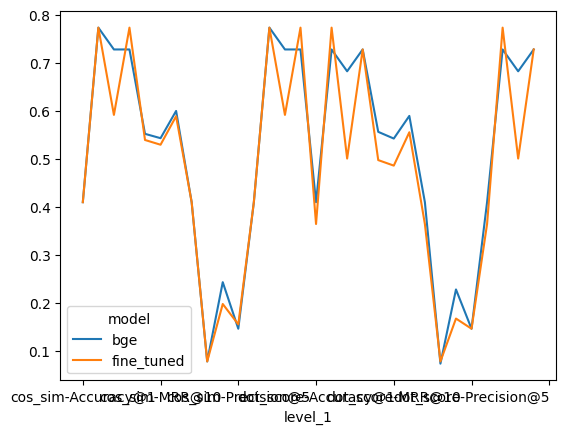

In [66]:
df_st_all_2.iloc[:-2, :].plot()